# ✈️ Predicción de Precio de Vuelos ✈️

![name](https://drive.google.com/uc?export=view&id=1wKT1e8hgGxfgzwguVXDf-7KUmg-YazpN)



##Introducción

***Contexto comercial:*** 
En la actualidad, las empresas que venden boletos de avión online necesitan conocer el valor de los boletos para elaborar promociones en su sitio web, y así poder atraer más clientes.
Pero se encuentran con un problema, y es que el valor de los tickets depende de muchas variables y cambia con el correr de los días.

***Objetivo:***
Este proyecto pretende, mediante el uso de diferentes herramientas, facilitar el análisis de la fluctuación de precios y permitir el uso de un modelo fiable para la predicción de los mismos. 

***Audiencia:***
Empresas de viaje

***Contexto analítico:***
Mediante el análisis de los datos, se intentará conocer cómo influyen las distintas variables en el precio y probar la validez de ciertas hipótesis iniciales. Además, se utilizarán distintos modelos predictivos, se seleccionará el mejor de ellos (basándose en determinadas métricas) que sea capaz de realizar una buena predicción del precio del ticket.
Para este propósito, se utilizará un dataset de compra de tickets de avión obtenido de la página 'EaseMyTrip'. Dicho dataset contiene 300k registros de compras en un rango de 50 días, desde Febrero a Marzo del 2022. Los vuelos son entre las 6 ciudades más grandes de India. 

![name](https://drive.google.com/uc?export=view&id=1WIQXetE92PF7mY97rmeKuc-OBbj1spgO)


## Hipótesis

**1)** A mayor duración de vuelo, mayor precio 

**2)** A mayor cantidad de días restantes para el vuelo, menor precio 

**3)** Aerolínea con precio de ticket más elevado es Vistara y el menor es AirAsia

**4)** Las siguientes combinaciones son las más baratas (por proximidad):

[*Ciudad origen*] ---------> [*Ciudad destino*]

Hyderabad ---------> Mumbai

Chennai ---------> Hyderabad

Bangalore ---------> Chennai

Delhi ---------> Kolkata

Kolkata ---------> Delhi

Chennai ---------> Bangalore

**5)** Los vuelos directos (cero escalas) presentan menor precio

**6)** Los vuelos que salen muy temprano (Early morning) son los más elegidos




## Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import xgboost as xgb
from sklearn import metrics
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, RobustScaler)
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_validate, KFold)
from sklearn.metrics import (mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score)
from sklearn.tree import (DecisionTreeRegressor, plot_tree)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (GradientBoostingRegressor, IsolationForest, RandomForestRegressor)
from sklearn.linear_model import (LinearRegression, Lasso, Ridge)
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from scipy import stats
from xgboost import XGBRegressor

In [2]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.2/859.2 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [3]:
from mpl_toolkits.basemap import Basemap

In [4]:
!pip install sidetable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import sidetable as stb

## Data Wrangling

Proceso de limpieza de datos crudos para facilitar el acceso,  análisis y modelado. 

Importamos el dataset

In [6]:
flight = pd.read_csv('https://raw.githubusercontent.com/micaelamuzi/Coder_Data_Science/main/Clean_Dataset_original.csv')

Primera visualización del dataset

In [7]:
flight.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [8]:
flight.shape

(300153, 12)

In [9]:
flight = flight.drop('Unnamed: 0', axis = 'columns')

In [10]:
flight.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [11]:
flight.dtypes

airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

In [12]:
flight.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.221021,7.191997,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.004751,13.561004,1.00,15.00,26.00,38.00,49.00
price,300153.0,20889.660523,22697.767366,1105.00,4783.00,7425.00,42521.00,123071.00


In [13]:
flight.describe(include='O').T

,count,unique,top,freq
airline,300153,6,Vistara,127859
flight,300153,1561,UK-706,3235
source_city,300153,6,Delhi,61343
departure_time,300153,6,Morning,71146
stops,300153,3,one,250863
arrival_time,300153,6,Night,91538
destination_city,300153,6,Mumbai,59097
class,300153,2,Economy,206666


### Valores nulos

In [14]:
print(flight.isnull().sum())

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


No se observan valores nulos

### Valores duplicados

In [15]:
flight.duplicated().sum()

0

### Primeros insights
* El dataset cuenta con 300.000 rows y 12 columnas
* 8 variables categóricas (string) y 3 numéricas
* No se observan valores nulos
* No se observan valores duplicados
* Variable 'flight' es prescindible
* El promedio de la variable 'price' es mucho mayor que la mediana (2do cuartil). Esto indica que está sesgada a la derecha
* Presencia de outliers
* Casi la mitad de los vuelos se realizaron con aerolínea Vistara, la gran mayoría en clase Economy y de 1 escala
* Se convertirá la variable 'price' de rupias a dólares

### Transformación

Conversión de rupias a dólares

In [16]:
flight['price_usd'] = flight['price']*0.012

In [17]:
flight = flight.drop({'price'}, axis = 'columns')

Se quitan los decimales convirtiendo el formato de la columna 'price_usd' a integer

In [18]:
flight['price_usd'] = flight['price_usd'].astype(int)

In [19]:
flight.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price_usd
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,71
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,71
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,71
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,71
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,71


In [20]:
flight_label = flight

Se asignan valores numéricos a las variables categóricas para poder utilizarlas en un modelo de regresión (Label Encoding)

In [21]:
flight.airline.unique()

array(['SpiceJet', 'AirAsia', 'Vistara', 'GO_FIRST', 'Indigo',
       'Air_India'], dtype=object)

In [22]:
airline_id = {  'SpiceJet': 1,
                'AirAsia': 2,
                'Vistara': 3,
                'GO_FIRST': 4,
                'Indigo': 5,
                'Air_India': 6}
flight['airline_id'] = flight.airline.map(airline_id)

In [23]:
flight.source_city.unique()

array(['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai'],
      dtype=object)

In [24]:
source_city_id = {  'Delhi': 1,
                    'Mumbai': 2,
                    'Bangalore': 3,
                    'Kolkata': 4,
                    'Hyderabad': 5,
                    'Chennai': 6}
flight['source_city_id'] = flight.source_city.map(source_city_id)

In [25]:
flight.departure_time.unique()

array(['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night',
       'Late_Night'], dtype=object)

In [26]:
departure_time_id = { 'Early_Morning': 1,
                      'Morning': 2,
                      'Afternoon': 3,
                      'Evening': 4,
                      'Night': 5,
                      'Late_Night': 6}
flight['departure_time_id'] = flight.departure_time.map(departure_time_id)

In [27]:
flight.stops.unique()

array(['zero', 'one', 'two_or_more'], dtype=object)

In [28]:
stops_id = {  'zero': 0,
              'one': 1,
              'two_or_more': 2}
flight['stops_id'] = flight.stops.map(stops_id)

In [29]:
flight.arrival_time.unique()

array(['Night', 'Morning', 'Early_Morning', 'Afternoon', 'Evening',
       'Late_Night'], dtype=object)

In [30]:
arrival_time_id = {   'Early_Morning': 1,
                      'Morning': 2,
                      'Afternoon': 3,
                      'Evening': 4,
                      'Night': 5,
                      'Late_Night': 6}
flight['arrival_time_id'] = flight.arrival_time.map(arrival_time_id)

In [31]:
flight.destination_city.unique()

array(['Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai', 'Delhi'],
      dtype=object)

In [32]:
destination_city_id = { 'Delhi': 1,
                        'Mumbai': 2,
                        'Bangalore': 3,
                        'Kolkata': 4,
                        'Hyderabad': 5,
                        'Chennai': 6}
flight['destination_city_id'] = flight.destination_city.map(destination_city_id)

In [33]:
flight = flight.rename(columns={'class': 'class_flight'})

In [34]:
flight.class_flight.unique()

array(['Economy', 'Business'], dtype=object)

In [35]:
class_id = {  'Economy': 0,
              'Business': 1}
flight['class_id'] = flight.class_flight.map(class_id)

Resumen variables categóricas:

1. **Aerolínea ('airline_id')**
* 'SpiceJet': 1
* 'AirAsia': 2 
* 'Vistara': 3 
* 'GO_FIRST': 4 
* 'Indigo': 5
* 'Air_India': 6

2. **Ciudad origen ('source_city_id')** 
* 'Delhi': 1
* 'Mumbai': 2
* 'Bangalore': 3
* 'Kolkata': 4
* 'Hyderabad': 5
* 'Chennai': 6

3. **Ciudad destino  ('destination_city_id')** 
* (mismas referencias que Ciudad origen)

4. **Hora de partida ('departure_time_id')** 
* 'Early_Morning': 1
* 'Morning': 2 
* 'Afternoon': 3
* 'Evening': 4
* 'Night': 5
* 'Late_Night': 6

5. **Hora de llegada ('arrival_time_id')** 
* (mismas referencias que Hora de partida)

6. **Escalas ('stops_id')** 
* 'zero': 0
* 'one': 1
* 'two_or_more': 2}

7. **Clase ('class_id')**
* 'Economy': 0,
* 'Business': 1

Variables continuas:

8. **Duración del vuelo ('duration')**

9. **Días restantes al vuelo ('days_left')**

10. **Precio ('price_usd')**

In [36]:
flight = flight.drop({'flight', 'airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class_flight'}, axis = 'columns')

In [37]:
flight = flight[['duration', 'days_left', 'airline_id', 'source_city_id', 'destination_city_id', 'departure_time_id', 'arrival_time_id', 'stops_id',  'class_id', 'price_usd']]

In [38]:
flight.head()

,duration,days_left,airline_id,source_city_id,destination_city_id,departure_time_id,arrival_time_id,stops_id,class_id,price_usd
0,2.17,1,1,1,2,4,5,0,0,71
1,2.33,1,1,1,2,1,2,0,0,71
2,2.17,1,2,1,2,1,1,0,0,71
3,2.25,1,3,1,2,2,3,0,0,71
4,2.33,1,3,1,2,2,2,0,0,71


In [39]:
flight.dtypes

duration               float64
days_left                int64
airline_id               int64
source_city_id           int64
destination_city_id      int64
departure_time_id        int64
arrival_time_id          int64
stops_id                 int64
class_id                 int64
price_usd                int64
dtype: object

In [40]:
flight_label = flight_label.drop({'airline_id', 'source_city_id', 'departure_time_id', 'stops_id', 'arrival_time_id', 'destination_city_id'}, axis = 'columns')

In [41]:
flight_label = flight_label.rename(columns={'class': 'class_flight'})

In [42]:
flight_label.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class_flight,duration,days_left,price_usd
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,71
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,71
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,71
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,71
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,71


## Análisis Exploratorio de Datos (EDA)

A continuación exploraremos los datos disponibles y analizaremos la correlación entre las variables.

### Análisis Univariado

[Text(0.5, 1.0, 'Aerolíneas')]

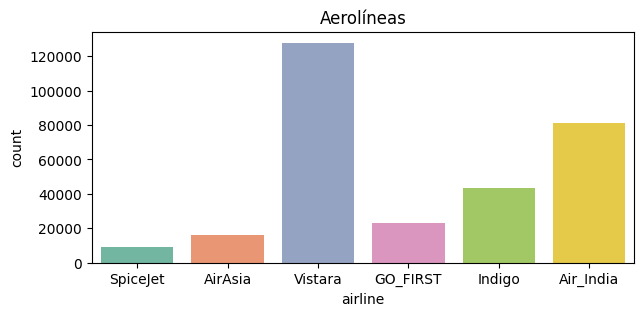

In [ ]:
plt.figure(figsize=(7, 3))
sns.countplot(data = flight_label, x = 'airline', palette = 'Set2').set(title='Aerolíneas')

In [ ]:
flight_label.stb.freq(['airline'])

,airline,count,percent,cumulative_count,cumulative_percent
0,Vistara,127859,42.597942,127859,42.597942
1,Air_India,80892,26.950255,208751,69.548197
2,Indigo,43120,14.366007,251871,83.914204
3,GO_FIRST,23173,7.720396,275044,91.634600
4,AirAsia,16098,5.363265,291142,96.997864
5,SpiceJet,9011,3.002136,300153,100.000000


In [ ]:
flight_label.stb.freq(['departure_time'])

,departure_time,count,percent,cumulative_count,cumulative_percent
0,Morning,71146,23.703245,71146,23.703245
1,Early_Morning,66790,22.251985,137936,45.955229
2,Evening,65102,21.689605,203038,67.644834
3,Night,48015,15.996842,251053,83.641676
4,Afternoon,47794,15.923212,298847,99.564889
5,Late_Night,1306,0.435111,300153,100.000000


In [ ]:
flight_label.stb.freq(['arrival_time'])

,arrival_time,count,percent,cumulative_count,cumulative_percent
0,Night,91538,30.497113,91538,30.497113
1,Evening,78323,26.094359,169861,56.591472
2,Morning,62735,20.901007,232596,77.492479
3,Afternoon,38139,12.706520,270735,90.198999
4,Early_Morning,15417,5.136380,286152,95.335379
5,Late_Night,14001,4.664621,300153,100.000000


In [ ]:
flight_label.stb.freq(['stops'])

,stops,count,percent,cumulative_count,cumulative_percent
0,one,250863,83.578375,250863,83.578375
1,zero,36004,11.995216,286867,95.573591
2,two_or_more,13286,4.426409,300153,100.000000


In [ ]:
flight_label.stb.freq(['class_flight'])

,class_flight,count,percent,cumulative_count,cumulative_percent
0,Economy,206666,68.853551,206666,68.853551
1,Business,93487,31.146449,300153,100.000000


In [ ]:
flight_label.stb.freq(['source_city'])

,source_city,count,percent,cumulative_count,cumulative_percent
0,Delhi,61343,20.437244,61343,20.437244
1,Mumbai,60896,20.288320,122239,40.725563
2,Bangalore,52061,17.344821,174300,58.070384
3,Kolkata,46347,15.441125,220647,73.511509
4,Hyderabad,40806,13.595067,261453,87.106576
5,Chennai,38700,12.893424,300153,100.000000


In [ ]:
flight_label.stb.freq(['destination_city'])

,destination_city,count,percent,cumulative_count,cumulative_percent
0,Mumbai,59097,19.688959,59097,19.688959
1,Delhi,57360,19.110254,116457,38.799212
2,Bangalore,51068,17.013990,167525,55.813202
3,Kolkata,49534,16.502917,217059,72.316119
4,Hyderabad,42726,14.234740,259785,86.550859
5,Chennai,40368,13.449141,300153,100.000000


Se observa que:
* Las aerolíneas Vistara y AirIndia concentran casi el 70% de los vuelos. SpiceJet posee la menor cantidad de vuelos.
* Los horarios más populares para partir son Morning, Early morning y Evening
* Los horarios más populares para llegar son Night, Evening y Morning
* La mayoría de los vuelos poseen 1 escala (83%)
* El 68% de los vuelos se hicieron en clase Economy
* Delhi y Mumbai son las ciudades con mayor cantidad de vuelos

### Análisis Bivariado y Multivariado

In [43]:
flight_economy = flight_label[flight_label.class_flight == 'Economy']
flight_business = flight_label[flight_label.class_flight == 'Business']

Distribución del precio de los boletos según la clase

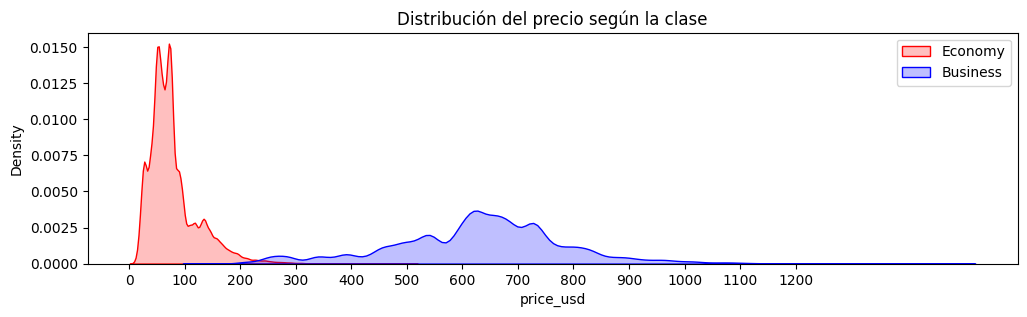

In [47]:
plt.figure(figsize=(12, 3))
fig = sns.kdeplot(flight_economy['price_usd'], fill=True, color="r", label='Economy')
fig = sns.kdeplot(flight_business['price_usd'], fill=True, color="b", label='Business')
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
plt.title('Distribución del precio según la clase')
plt.legend()

In [ ]:
flight_economy.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,206666.0,11.550060,7.241284,0.83,6.25,10.17,15.25,49.83
days_left,206666.0,26.123673,13.529610,1.00,15.00,26.00,38.00,49.00
price_usd,206666.0,78.375616,44.918316,13.00,50.00,69.00,92.00,508.00


In [ ]:
flight_business.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,93487.0,13.704274,6.852555,1.0,8.83,13.08,17.83,47.75
days_left,93487.0,25.741857,13.626538,1.0,14.00,26.00,38.00,49.00
price_usd,93487.0,630.009210,155.632415,144.0,542.00,637.00,724.00,1476.00


Se observa que, para boletos tipo Economy, el rango de precios va desde 13 a 508 usd, mientras que la clase Business tiene un rango mucho más amplio de precios, que varían desde 144 hasta 1476.

Relación del precio con los días restantes al vuelo:

In [ ]:
flight_daysleft_economy = flight_economy.groupby(['days_left'])['price_usd'].mean().reset_index()
flight_daysleft_business = flight_business.groupby(['days_left'])['price_usd'].mean().reset_index()

([<matplotlib.axis.XTick at 0x7f48c65c9610>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45'),
  Text(50, 0, '50')])

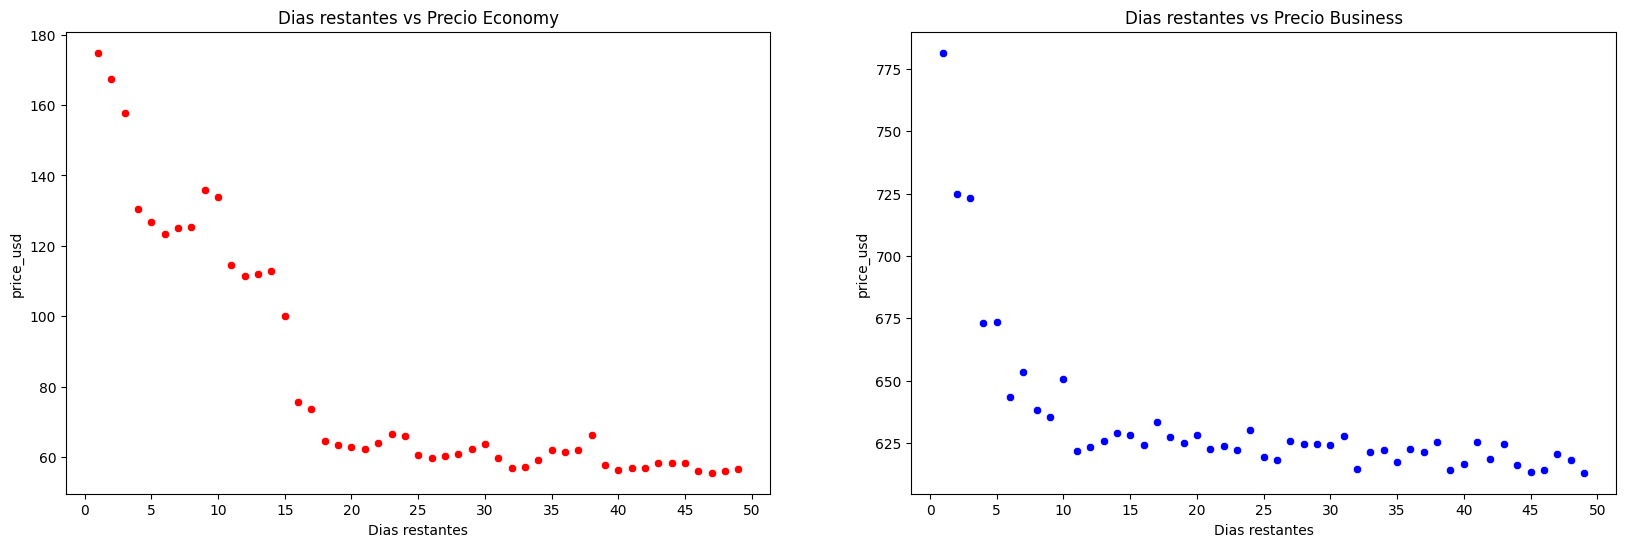

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
sns.scatterplot(data=flight_daysleft_economy, x="days_left", y="price_usd", color="r").set(title='Dias restantes vs Precio Economy')
plt.xlabel("Dias restantes")
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.subplot(1,2,2)
sns.scatterplot(data=flight_daysleft_business, x="days_left", y="price_usd", color="b").set(title='Dias restantes vs Precio Business')
plt.xlabel("Dias restantes")
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

Si calculamos la media del precio agrupando por cantidad de días restantes al vuelo, para clase Economy se observa un precio mayor claramente definido en el rango de los últimos 15 días antes de partir. Mientras que para Business el rango es en los últimos 5 días.

Relación con las distintas aerolíneas:

Text(0.5, 1.0, 'Aerolinea vs Precio Business')

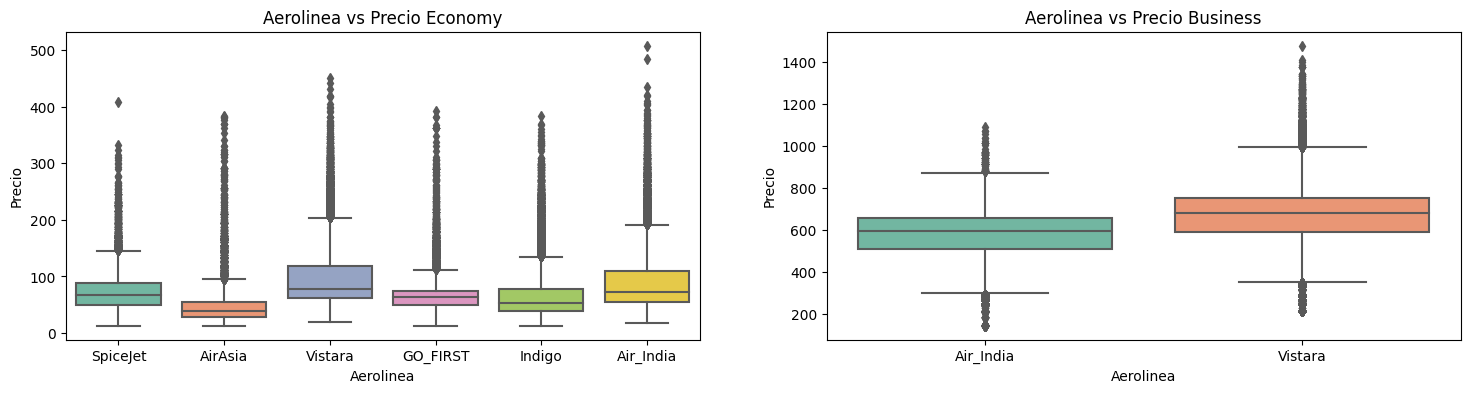

In [ ]:
plt.figure(figsize=(18,4))

plt.subplot(1,2,1)
sns.boxplot(data = flight_economy, x='airline', y='price_usd', palette = 'Set2')
plt.xlabel('Aerolinea')
plt.ylabel('Precio')
plt.title('Aerolinea vs Precio Economy')
plt.subplot(1,2,2)
sns.boxplot(data = flight_business, x='airline', y='price_usd', palette = 'Set2')
plt.xlabel('Aerolinea')
plt.ylabel('Precio')
plt.title('Aerolinea vs Precio Business')

Vistara y Air India presentan los mayores precios, con un máximo de Air India cerca de los 500 usd en Economy, mientras que AirAsia tiene los menores precios. En cuanto a clase Business, Vistara tiene mayores precios que Air India. Se presentan outliers.

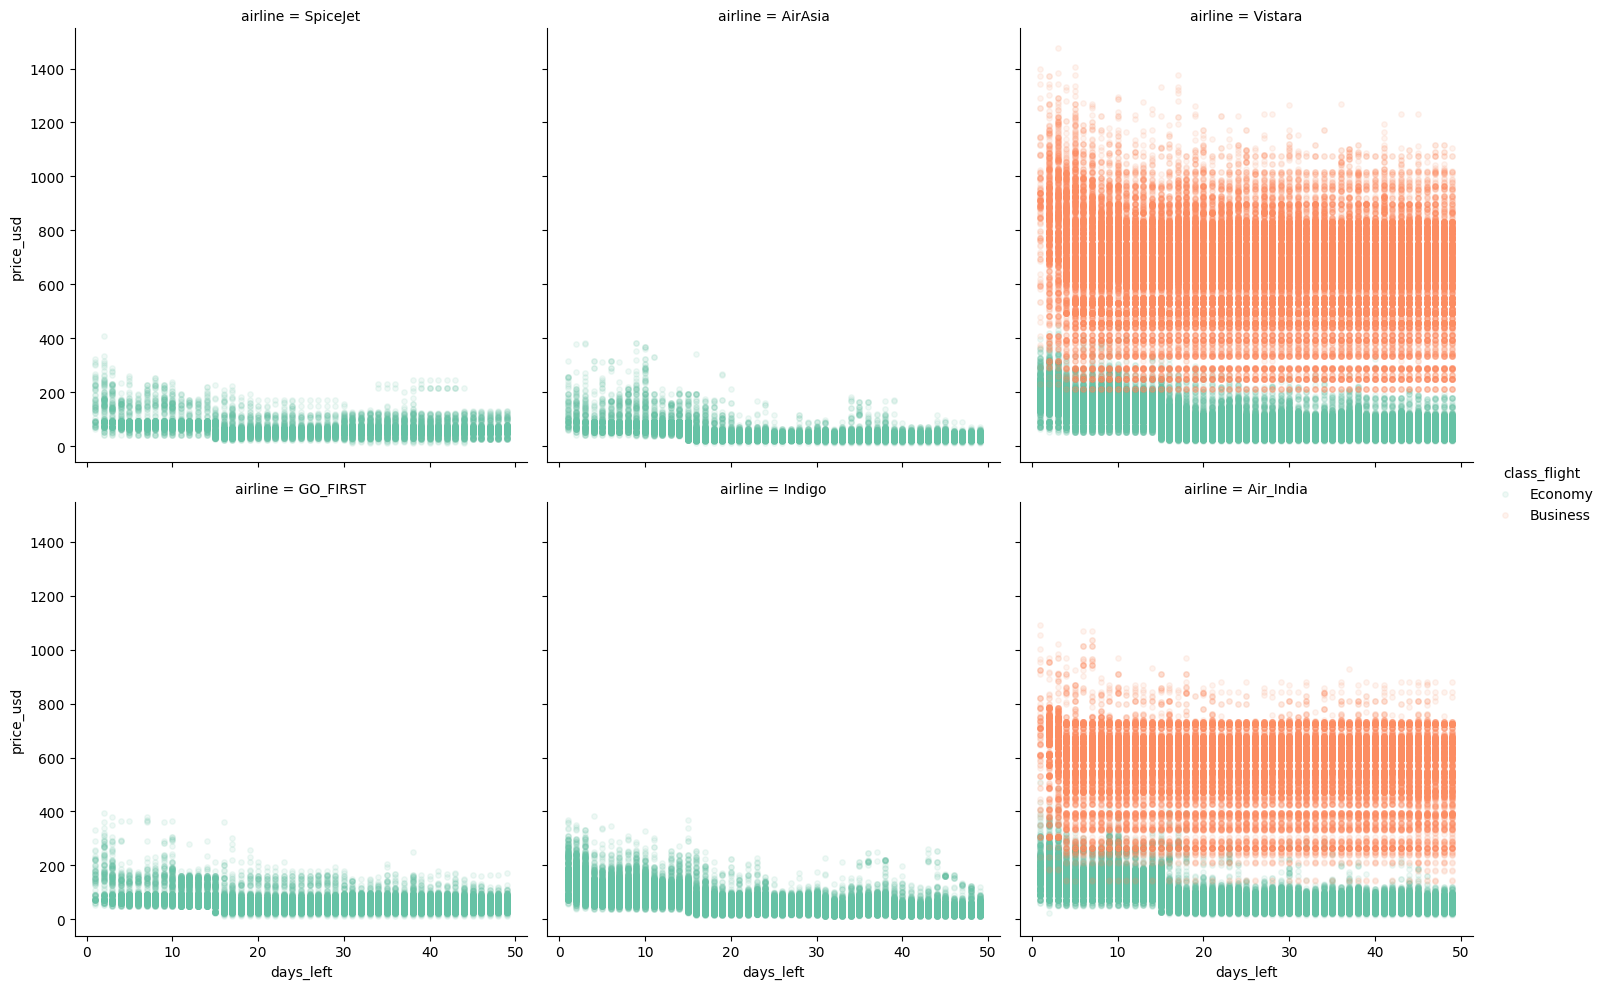

In [70]:
sns.lmplot(x='days_left', y='price_usd', data=flight_label, fit_reg=False, col='airline', hue='class_flight', legend=True, 
           palette="Set2", scatter_kws={"alpha":0.1,"s":15}, col_wrap=3)

Evaluando el precio vs los días restantes, si se diferencia por aerolínea, se ven precios un poco más elevados en Vistara en viajes Economy. En todas se mantiene el mismo patrón de aumento del precio a medida que se acerca la fecha del vuelo. Existe una alta variación de precios de viajes Business.

Relación con las distintas ciudades:

In [ ]:
pd.crosstab(flight_label['source_city'] , flight_label['destination_city'])

destination_city,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
source_city,,,,,,
Bangalore,0,6410,13756,8928,10028,12939
Chennai,6493,0,9783,6103,6983,9338
Delhi,14012,10780,0,9328,11934,15289
Hyderabad,7854,6395,8506,0,7987,10064
Kolkata,9824,6653,10506,7897,0,11467
Mumbai,12885,10130,14809,10470,12602,0


La combinación más frecuente es Delhi -> Mumbai

La menos frecuente es Chennai -> Hyderabad

<Axes: xlabel='destination_city', ylabel='price_usd'>

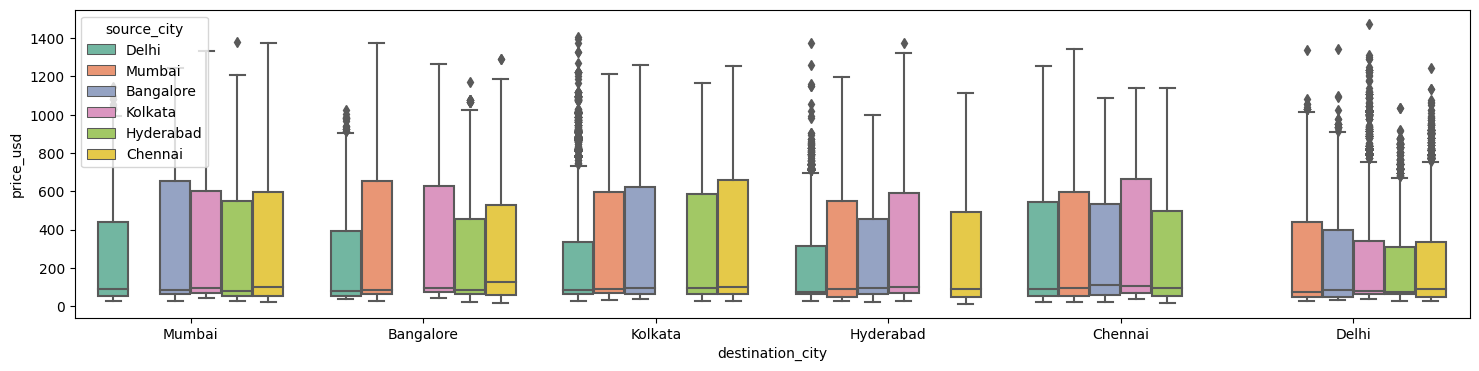

In [ ]:
plt.figure(figsize=(18, 4))
sns.boxplot(data=flight_label, x='destination_city', y='price_usd', hue= 'source_city', palette = 'Set2')

De este gráfico se interpreta que las siguientes combinaciones son las más económicas:

[*Ciudad origen*] ---------> [*Ciudad destino*]

Hyderabad ---------> Delhi

Delhi ---------> Mumbai

Delhi ---------> Bangalore

Delhi ---------> Kolkata

Delhi ---------> Hyderabad

Hyderabad ---------> Chennai

A continuación, visualizamos en un bubble map las ciudades y la cantidad de vuelos correspondientes (n).

In [ ]:
flight_label['source_city'].value_counts()

Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: source_city, dtype: int64

In [ ]:
cities = {
    'City': ["Delhi", "Mumbai", "Bangalore", "Kolkata", "Hyderabad", "Chennai"],
    'Lat': [28, 19, 12, 26, 17, 13],
    'Lon': [77, 72, 77, 76, 78, 80],
    'n': [61343, 60896, 52061, 46347, 40806, 38700],
    'color': ['black', 'yellow', 'blue', 'red', 'green', 'white']
}

In [ ]:
cities = pd.DataFrame(cities, columns = ['City', 'Lat', 'Lon', 'n', 'color'])
cities.head(10)

,City,Lat,Lon,n,color
0,Delhi,28,77,61343,black
1,Mumbai,19,72,60896,yellow
2,Bangalore,12,77,52061,blue
3,Kolkata,26,76,46347,red
4,Hyderabad,17,78,40806,green
5,Chennai,13,80,38700,white


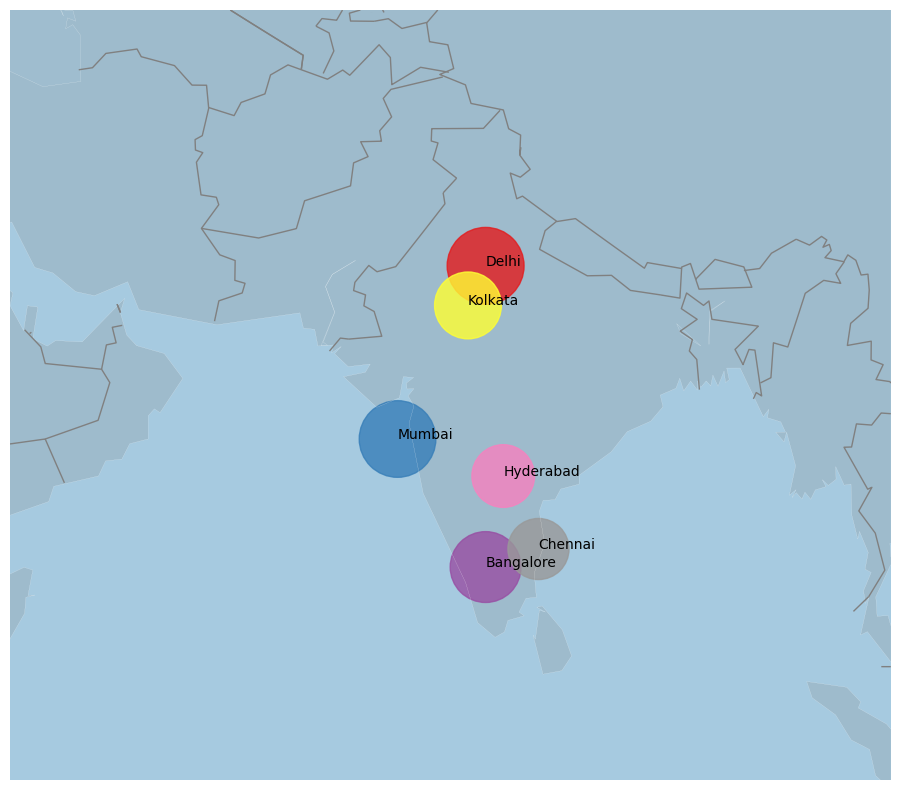

In [ ]:
plt.rcParams["figure.figsize"]=15,10;
m=Basemap(llcrnrlon=50, llcrnrlat=0, urcrnrlon=100, urcrnrlat=40, projection='merc')
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.2)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcountries(color='grey', linewidth=1)

cities['color'] = pd.factorize(cities['City'])[0]

m.scatter(
    x=m(cities['Lon'], cities['Lat'])[0], 
    y=m(cities['Lon'], cities['Lat'])[1], 
    s=cities['n']/20, 
    alpha=0.8, 
    c=cities['color'], 
    cmap="Set1"
)

for i in range(cities.shape[0]):
    x = cities['Lon'][i]
    y = cities['Lat'][i]
    tx = cities['City'][i]
    xx, yy = m(x, y)
    plt.text(xx, yy, tx, fontsize=10)

Relación con los horarios elegidos para viajar:

In [ ]:
pd.crosstab(flight_label['source_city'] , flight_label['departure_time'])

departure_time,Afternoon,Early_Morning,Evening,Late_Night,Morning,Night
source_city,,,,,,
Bangalore,5183,13611,14243,457,12323,6244
Chennai,5807,9319,5402,72,10550,7550
Delhi,11234,12248,16790,357,13679,7035
Hyderabad,7221,8524,5991,38,9923,9109
Kolkata,7863,8133,9594,114,12065,8578
Mumbai,10486,14955,13082,268,12606,9499


El horario de salida más elegido por los usuarios varía con la ciudad. Por ejemplo, en el caso de Bangalore es Evening, mientras que para Chennai es Morning.

Text(0.5, 1.0, 'Horario de llegada vs Precio')

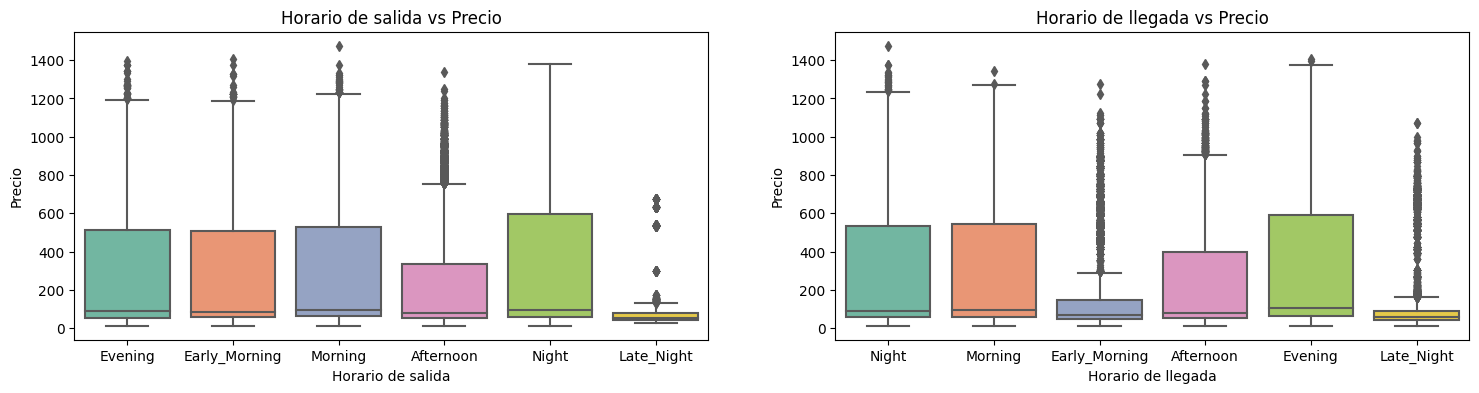

In [ ]:
plt.figure(figsize=(18, 4))

plt.subplot(1,2,1)
sns.boxplot(data=flight_label, x='departure_time', y='price_usd', palette = 'Set2')
plt.xlabel('Horario de salida')
plt.ylabel('Precio')
plt.title('Horario de salida vs Precio')
plt.subplot(1,2,2)
sns.boxplot(data=flight_label, x='arrival_time', y='price_usd', palette = 'Set2')
plt.xlabel('Horario de llegada')
plt.ylabel('Precio')
plt.title('Horario de llegada vs Precio')

Encontramos precios menores para salir en Late Night y Afternoon, mientras que los horarios de llegada son más económicos en Early Morning y Late Night.

Relación con la cantidad de escalas:

Text(0.5, 1.0, 'Escalas vs Precio Business')

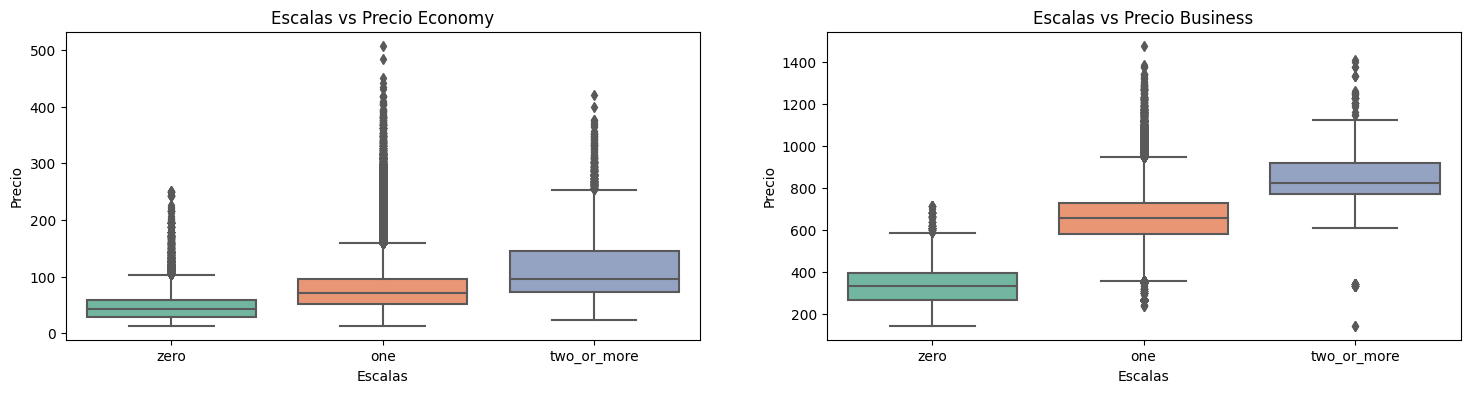

In [ ]:
plt.figure(figsize=(18,4))

plt.subplot(1,2,1)
sns.boxplot(data = flight_economy, x='stops', y='price_usd', palette = 'Set2')
plt.xlabel('Escalas')
plt.ylabel('Precio')
plt.title('Escalas vs Precio Economy')
plt.subplot(1,2,2)
sns.boxplot(data = flight_business, x='stops', y='price_usd', palette = 'Set2')
plt.xlabel('Escalas')
plt.ylabel('Precio')
plt.title('Escalas vs Precio Business')

Si diferenciamos por cantidad de escalas, se observan menores precios en vuelos directos, mientras  que los vuelos de 1 escala presentan el precio máximo.

Relación con la duración:

In [ ]:
flight_duration_economy = flight_economy.groupby(['duration'])['price_usd'].mean().reset_index()
flight_duration_business = flight_business.groupby(['duration'])['price_usd'].mean().reset_index()

([<matplotlib.axis.XTick at 0x7f48bdab7d90>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45'),
  Text(50, 0, '50')])

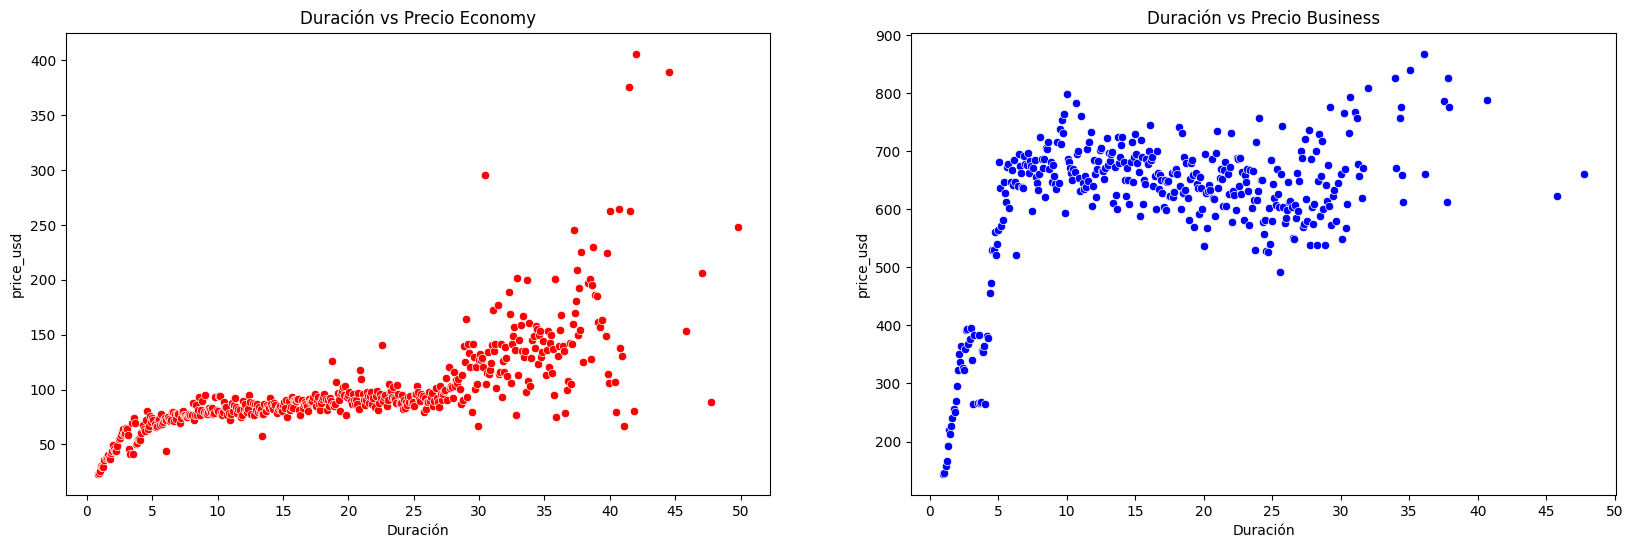

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
sns.scatterplot(data=flight_duration_economy, x="duration", y="price_usd", color="r").set(title='Duración vs Precio Economy')
plt.xlabel("Duración")
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.subplot(1,2,2)
sns.scatterplot(data=flight_duration_business, x="duration", y="price_usd", color="b").set(title='Duración vs Precio Business')
plt.xlabel("Duración")
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

Si consideramos la media del precio agrupando por duración del vuelo, para clase Economy se observa un aumento del precio a partir de las 25 hs. En el caso de Business, el precio va aumentando hasta las 10 hs, a partir del cual  se mantiene estable.

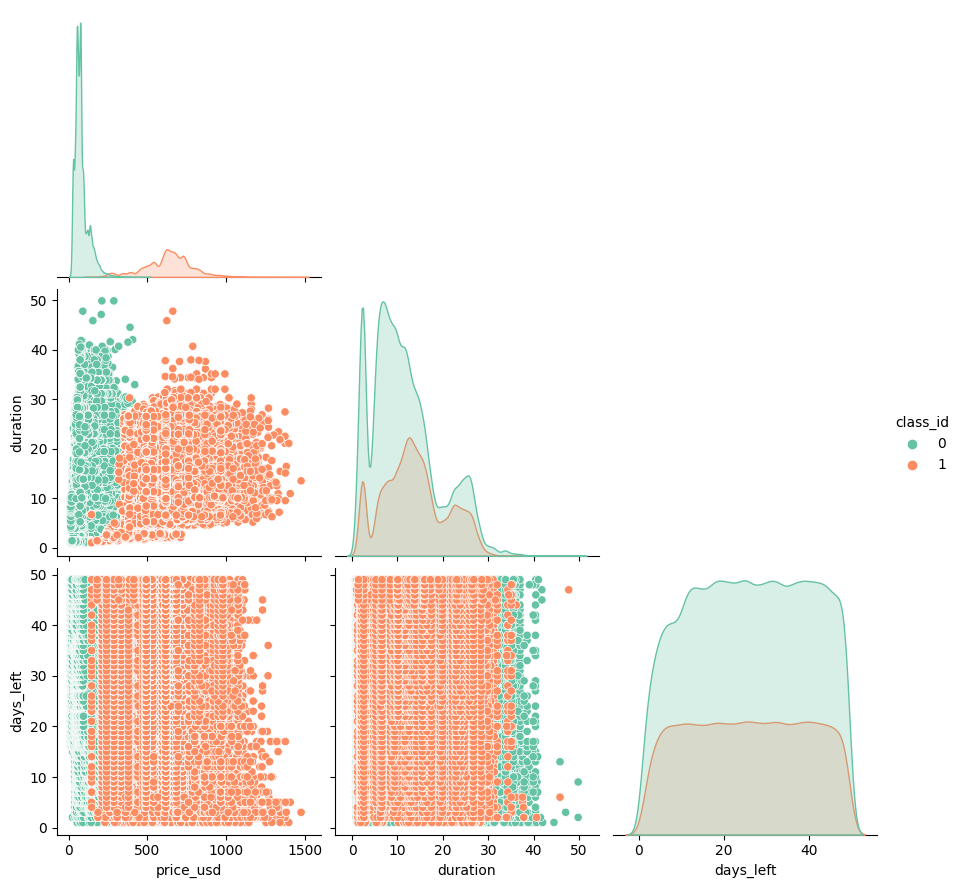

In [ ]:
sns.pairplot(flight, vars=['price_usd', 'duration', 'days_left'], diag_kind = 'kde', corner = True, hue = 'class_id' , height = 3 , palette = 'Set2')

No se observa a simple vista una relación relevante, aparte de las ya mencionadas

Observemos cuál es la relación entre las variables mediante un heat map

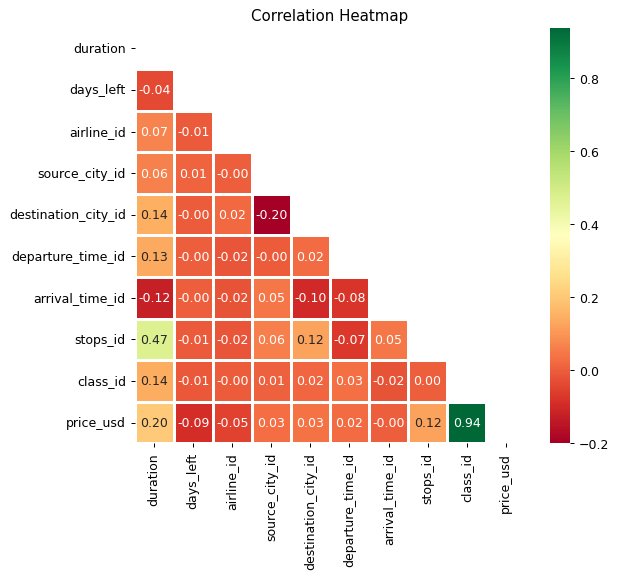

In [ ]:
plt.figure(dpi = 90, figsize= (7,6))
mask = np.triu(np.ones_like(flight.corr(),dtype = bool))
sns.heatmap(flight.corr(),mask = mask, fmt = ".2f", annot=True, lw=1, cmap = 'RdYlGn')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

Se puede observar una alta correlación entre el precio y la clase (Economy o Business). Una menor correlación encontramos entre el precio y la duración del vuelo. Por otro lado, hay una alta correlación entre la duración y la cantidad de escalas.

## Modelos

Se utilizará un modelo de regresión para pronosticar la variable 'price_usd' (target), comenzando por statsmodels de Python. Además se probarán los modelos Ridge y Lasso, que son variaciones del modelo de regresión lineal.

Luego se dividirán los registros del dataset en un subgrupo de training y un subgrupo de testing, se probarán los modelos Dummy Regressor, Decision tree, XGBoost, KNN y Random Forest y se decidirá cuál es el más adecuado.



### Métricas

Para evaluar la eficiencia de todos los modelos, evaluamos 4 métricas:

R2: Devuelve el porcentaje de la variación observada en la variable dependiente que se explica por las variables independientes. Aumenta a medida que se agregan más variables independientes en los modelos.

![name](https://drive.google.com/uc?export=view&id=1KQSxQ05J87PbGpsILe1xZl2NBlDhIZ5T)

RMSE: Raíz del error cuadrático medio. El objetivo es que sea lo menor posible, ya que mide las diferencias entre los valores reales y los pronosticados, penalizando más las grandes diferencias que las pequeñas.

![name](https://drive.google.com/uc?export=view&id=1eCK4Q5djMUXqMW1UL5XdpfSUzJKKqRK4)

MAE: Se calcula como la media de la diferencia absoluta entre los valores reales y predichos.

![name](https://drive.google.com/uc?export=view&id=1mXA06bG8uxrbBkUKEsOed10uN65x1YHw)

MAPE: Mide el error en términos de porcentaje.

![name](https://drive.google.com/uc?export=view&id=1Fm7tzyfXDXNc1-e4QIHJInL3dd15WEym)

### Regresión lineal

A continuación se utiliza el módulo statsmodels de Python para crear un modelo de regresión. Veamos cómo se comporta el modelo utilizando como variable independiente sólo 'days_left':

In [ ]:
model1 = 'price_usd~days_left'
lm1 = sm.ols(formula = model1, data = flight).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_usd   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2560.
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:20:42   Log-Likelihood:            -2.1076e+06
No. Observations:              300153   AIC:                         4.215e+06
Df Residuals:                  300151   BIC:                         4.215e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    298.2203      1.071    278.534      0.0

R-squared (R2) es casi 0, lo que demuestra que el modelo es muy pobre.

Ahora veamos qué sucede si agregamos la variable independiente 'stops_id'

In [ ]:
model2 = 'price_usd~days_left + stops_id'
lm2 = sm.ols(formula = model2, data = flight).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_usd   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3467.
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:20:42   Log-Likelihood:            -2.1055e+06
No. Observations:              300153   AIC:                         4.211e+06
Df Residuals:                  300150   BIC:                         4.211e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    222.5281      1.566    142.141      0.0

R2 aumentó, lo que significa que el modelo mejoró.

Si integramos todas las variables en el modelo:

In [ ]:
model3 = 'price_usd~days_left + stops_id + airline_id + source_city_id + destination_city_id + departure_time_id + arrival_time_id + class_id + duration'
lm3 = sm.ols(formula = model3, data = flight).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:              price_usd   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 3.120e+05
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:20:43   Log-Likelihood:            -1.7581e+06
No. Observations:              300153   AIC:                         3.516e+06
Df Residuals:                  300143   BIC:                         3.516e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              59.1680    

Como es esperable, R2 aumenta, convirtiendo al modelo 3 en el mejor hasta ahora.

Ahora veamos qué sucede si quitamos las variables "source_city_id", "destination_city_id", "departure_time_id" y "arrival_time_id" que tienen poca correlación con el precio

In [ ]:
model4 = 'price_usd~days_left + stops_id + airline_id + class_id + duration'
lm4 = sm.ols(formula = model3, data = flight).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:              price_usd   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 3.120e+05
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:20:43   Log-Likelihood:            -1.7581e+06
No. Observations:              300153   AIC:                         3.516e+06
Df Residuals:                  300143   BIC:                         3.516e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              59.1680    

Vemos que R2 se mantiene igual. Es por esto que se podría reducir la dimensionalidad del data frame quitando estas variables. Sin embargo, continuaremos trabajando con el data frame completo y más adelante se probará el método PCA.

In [ ]:
x = flight.drop(columns = ['price_usd'])
y = flight['price_usd']

In [ ]:
y_pred = lm3.predict(x)

In [ ]:
r2_reglineal = r2_score(y, y_pred)
rmse_reglineal = mean_squared_error(y, y_pred, squared=False)
mae_reglineal = mean_absolute_error(y, y_pred)
mape_reglineal = mean_absolute_percentage_error(y, y_pred)

In [ ]:
print("R2:", r2_reglineal)
print("RMSE:", rmse_reglineal)
print("MAE:", mae_reglineal)
print("MAPE:", mape_reglineal)

R2: 0.903438755119129
RMSE: 84.64063605602064
MAE: 55.197850388105024
MAPE: 0.4455678230997896


### Lasso

Uno de los hiperparámetros que utiliza este modelo es 'alpha', que controla la fuerza de la penalización aplicada a los coeficientes de las variables predictoras. Un valor alto de alpha resultará en una mayor penalización, lo que significa que más coeficientes se reducirán a cero y se eliminarán del modelo. Cuando alpha = 0, incluimos a todos los coeficientes en el modelo y equivale a utilizar el modelo Linear Regression.

In [ ]:
score_mape_lasso = []
alphas = [10, 7, 5, 3, 2, 1, 0.1]

In [ ]:
for alpha in alphas:
    lasso = Lasso(alpha=alpha).fit(x, y)
    y_pred = lasso.predict(x)
    score_mape_lasso.append(mean_absolute_error(y, y_pred))

In [ ]:
list(zip(alphas, score_mape_lasso))

[(10, 58.65754477350602),
 (7, 55.9131152716469),
 (5, 54.62933002938956),
 (3, 54.29145703395908),
 (2, 54.42015658569142),
 (1, 54.72714595765467),
 (0.1, 55.14406400758181)]

Cuando alpha = 3, MAE tiene el menor valor y por eso representa el mejor modelo.

In [ ]:
lasso = Lasso(alpha=3) 

lasso.fit(x, y)

y_pred = lasso.predict(x)

r2_lasso = r2_score(y, y_pred)
rmse_lasso = mean_squared_error(y, y_pred, squared=False)
mae_lasso = mean_absolute_error(y, y_pred)
mape_lasso = mean_absolute_percentage_error(y, y_pred)

In [ ]:
print("R2:", r2_lasso)
print("RMSE:", rmse_lasso)
print("MAE:", mae_lasso)
print("MAPE:", mape_lasso)

R2: 0.9016922860026438
RMSE: 85.40263861679634
MAE: 54.29145703395908
MAPE: 0.4041236378456832


### Ridge

In [ ]:
score_mape_ridge = []
alphas = [10, 7, 5, 3, 2, 1, 0.1]

In [ ]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(x, y)
    y_pred = ridge.predict(x)
    score_mape_ridge.append(mean_absolute_error(y, y_pred))

In [ ]:
list(zip(alphas, score_mape_ridge))

[(10, 55.198410314022354),
 (7, 55.198239871191724),
 (5, 55.19812749329881),
 (3, 55.19801593742996),
 (2, 55.19796054952053),
 (1, 55.197905365824916),
 (0.1, 55.197855873790935)]

In [ ]:
ridge = Ridge(alpha=0.1) 

ridge.fit(x, y)

y_pred = ridge.predict(x)

r2_ridge = r2_score(y, y_pred)
rmse_ridge = mean_squared_error(y, y_pred, squared=False)
mae_ridge = mean_absolute_error(y, y_pred)
mape_ridge = mean_absolute_percentage_error(y, y_pred)

In [ ]:
print("R2:", r2_ridge)
print("RMSE:", rmse_ridge)
print("MAE:", mae_ridge)
print("MAPE:", mape_ridge)

R2: 0.9034387551168638
RMSE: 84.64063605701344
MAE: 55.197855873790935
MAPE: 0.44556785146097355


### Dummy Regressor

Se crean los subgrupos de datos de training y de testing. Se entrenará el modelo con el 75% del total de los registros del dataset y se testeará con el 25% restante.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (225114, 9)
y_train: (225114,)
x_test: (75039, 9)
y_test: (75039,)


Ahora tenemos un subconjunto de training de 225114 registros, y un subconjunto de testing de 75039 registros.

In [ ]:
dummy = DummyRegressor()

In [ ]:
dummy.fit(x_train, y_train)

DummyRegressor()

In [ ]:
y_train_pred_dummy = dummy.predict(x_train)
y_test_pred_dummy = dummy.predict(x_test)

In [ ]:
y_test_pred_dummy

array([250.12152065, 250.12152065, 250.12152065, ..., 250.12152065,
       250.12152065, 250.12152065])

In [ ]:
r2_train_dummy = r2_score(y_train, y_train_pred_dummy)
r2_test_dummy = r2_score(y_test, y_test_pred_dummy)

rmse_train_dummy = mean_squared_error(y_train, y_train_pred_dummy, squared=False)
rmse_test_dummy = mean_squared_error(y_test, y_test_pred_dummy, squared=False)

mae_train_dummy = mean_absolute_error(y_train, y_train_pred_dummy)
mae_test_dummy = mean_absolute_error(y_test, y_test_pred_dummy)

mape_train_dummy = mean_absolute_percentage_error(y_train, y_train_pred_dummy)
mape_test_dummy = mean_absolute_percentage_error(y_test, y_test_pred_dummy)

In [ ]:
print("R2 train:", r2_train_dummy)
print("R2 test:", r2_test_dummy)
print('----------')
print("RMSE train:", rmse_train_dummy)
print("RMSE test:", rmse_test_dummy)
print('----------')
print("MAE train:", mae_train_dummy)
print("MAE test:", mae_test_dummy)
print('----------')
print("MAPE train:", mape_train_dummy)
print("MAPE test:", mape_test_dummy)

R2 train: 0.0
R2 test: -1.0071943874478961e-06
----------
RMSE train: 272.3433605529999
RMSE test: 272.4956258877772
----------
MAE train: 237.03552085835724
MAE test: 237.29138500606055
----------
MAPE train: 2.4055405339801905
MAPE test: 2.409828251521261


El modelo Dummy Regressor calcula el promedio de todos los valores del target y devuelve este como la predicción (podemos ver que el promedio es $250.12). Es por esto que es esperable una pésima performance del modelo, lo que se ve reflejado en las métricas.

### Decision tree

#### Modelo simple

A continuación veremos cómo trabaja este modelo predictivo. La primera prueba del modelo será con una profundidad igual a 3.

In [ ]:
tree_model1 = DecisionTreeRegressor(max_depth=3, random_state=42)

Se entrena el modelo:

In [ ]:
tree_model1.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

Profundidad del árbol: 3
Número de nodos terminales: 8


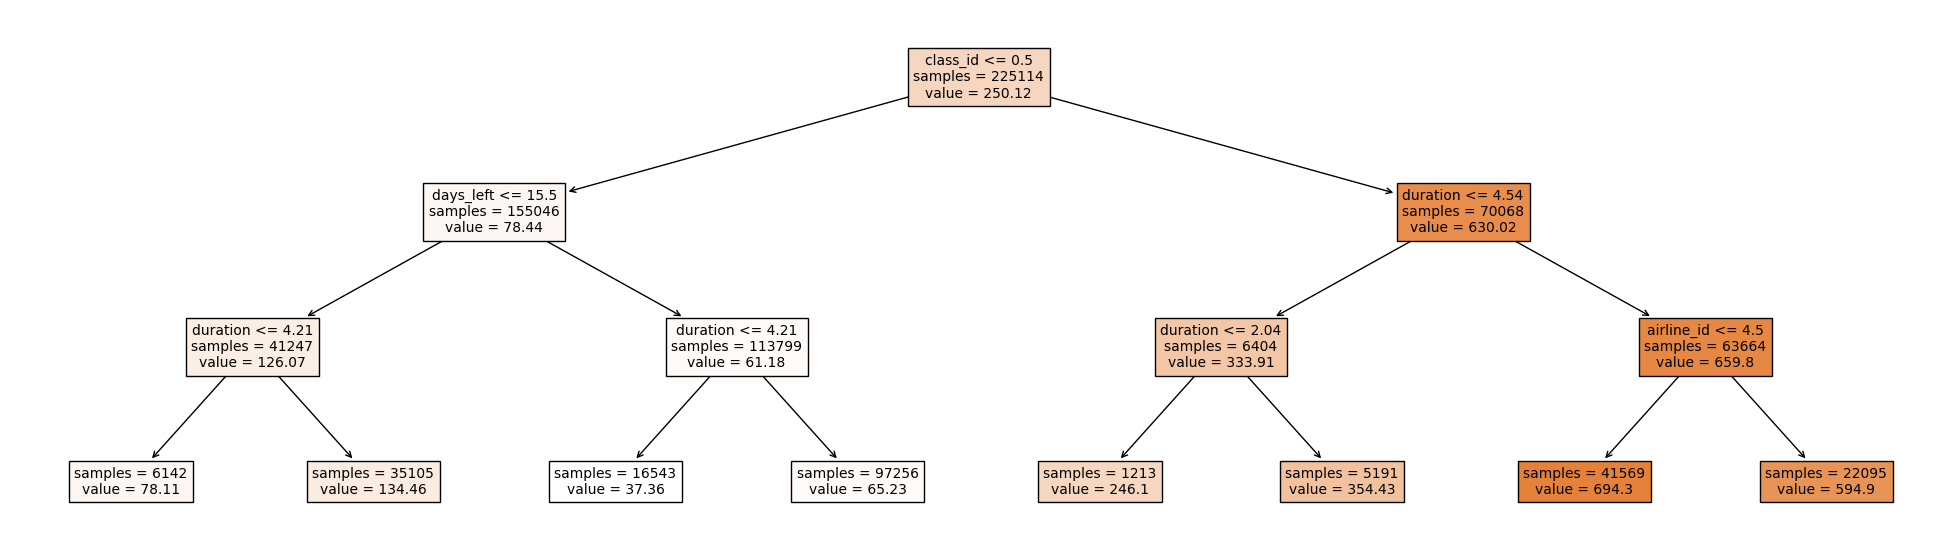

In [ ]:
fig, ax = plt.subplots(figsize=(25, 7))

print(f"Profundidad del árbol: {tree_model1.get_depth()}")
print(f"Número de nodos terminales: {tree_model1.get_n_leaves()}")

plot = plot_tree(
            decision_tree = tree_model1,
            feature_names = flight.drop(columns = "price_usd").columns,
            class_names   = 'price_usd',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

La interpretación del arbol es la siguiente: 

Si se cumple que:

'class_id' <= 0.5

&

'days_left' <= 15.5

&

'duration' <= 4.21

entonces el modelo predice un valor del boleto de $78.11


In [ ]:
y_train_pred_tree1 = tree_model1.predict(x_train)
y_test_pred_tree1 = tree_model1.predict(x_test)

In [ ]:
r2_train_tree1 = r2_score(y_train, y_train_pred_tree1)
r2_test_tree1 = r2_score(y_test, y_test_pred_tree1)

rmse_train_tree1 = mean_squared_error(y_train, y_train_pred_tree1, squared=False)
rmse_test_tree1 = mean_squared_error(y_test, y_test_pred_tree1, squared=False)

mae_train_tree1 = mean_absolute_error(y_train, y_train_pred_tree1)
mae_test_tree1 = mean_absolute_error(y_test, y_test_pred_tree1)

mape_train_tree1 = mean_absolute_percentage_error(y_train, y_train_pred_tree1)
mape_test_tree1 = mean_absolute_percentage_error(y_test, y_test_pred_tree1)

In [ ]:
print("R2 train:", r2_train_tree1)
print("R2 test:", r2_test_tree1)
print('----------')
print("RMSE train:", rmse_train_tree1)
print("RMSE test:", rmse_test_tree1)
print('----------')
print("MAE train:", mae_train_tree1)
print("MAE test:", mae_test_tree1)
print('----------')
print("MAPE train:", mape_train_tree1)
print("MAPE test:", mape_test_tree1)

R2 train: 0.9348694342688288
R2 test: 0.934080997904983
----------
RMSE train: 69.50390687582225
RMSE test: 69.96238865921035
----------
MAE train: 42.080349150636835
MAE test: 42.0451918805076
----------
MAPE train: 0.277122455754256
MAPE test: 0.2769465682954914


Las métricas mejoraron con respecto a los modelos expuestos anteriores

#### Grid Search CV


Ahora nos interesa conocer cuál es el valor de profundidad ideal para el modelo. 

Para esto, utlizaremos GridSearchCV: una técnica que encuentra los mejores hiperparámetros probando todas las combinaciones posibles que le pasemos, y evaluando el rendimiento con validación cruzada.

En este caso, le vamos a indicar diferentes valores de profundidad y de features y evaluar MAE.

In [ ]:
param_grid = {
    'max_depth': [50, 100, 300],
    'max_features': [5, 7, 10]
    }

In [ ]:
tree_model2 = DecisionTreeRegressor(random_state = 42)

In [ ]:
grid_search1 = GridSearchCV(estimator=tree_model2, param_grid=param_grid, n_jobs=-1, verbose=2, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
grid_search1.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [50, 100, 300],
                         'max_features': [5, 7, 10]},
             scoring='neg_mean_absolute_error', verbose=2)

Los mejores hiperparámetros obtenidos son:

In [ ]:
print(grid_search1.best_params_) 

{'max_depth': 50, 'max_features': 10}


In [ ]:
print(grid_search1.best_score_)

-14.71196582590017


In [ ]:
tree_model2 = DecisionTreeRegressor(max_depth=50, max_features= 10, random_state=42)

In [ ]:
tree_model2.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=50, max_features=10, random_state=42)

In [ ]:
y_train_pred_tree2 = tree_model2.predict(x_train)
y_test_pred_tree2 = tree_model2.predict(x_test)

In [ ]:
r2_train_tree2 = r2_score(y_train, y_train_pred_tree2)
r2_test_tree2 = r2_score(y_test, y_test_pred_tree2)

rmse_train_tree2 = mean_squared_error(y_train, y_train_pred_tree2, squared=False)
rmse_test_tree2 = mean_squared_error(y_test, y_test_pred_tree2, squared=False)

mae_train_tree2 = mean_absolute_error(y_train, y_train_pred_tree2)
mae_test_tree2 = mean_absolute_error(y_test, y_test_pred_tree2)

mape_train_tree2 = mean_absolute_percentage_error(y_train, y_train_pred_tree2)
mape_test_tree2 = mean_absolute_percentage_error(y_test, y_test_pred_tree2)

In [ ]:
print("R2 train:", r2_train_tree2)
print("R2 test:", r2_test_tree2)
print('----------')
print("RMSE train:", rmse_train_tree2)
print("RMSE test:", rmse_test_tree2)
print('----------')
print("MAE train:", mae_train_tree2)
print("MAE test:", mae_test_tree2)
print('----------')
print("MAPE train:", mape_train_tree2)
print("MAPE test:", mape_test_tree2)

R2 train: 0.9993141351233141
R2 test: 0.9754752848717414
----------
RMSE train: 7.132406278595636
RMSE test: 42.67379851625478
----------
MAE train: 0.664081309914088
MAE test: 14.209766476987523
----------
MAPE train: 0.002539400537847227
MAPE test: 0.07746609692868946


#### Detección de outliers

Utilizaremos Isolation Forest para detectar anomalías. Usando contamination = 0.1 le estamos indicando que un 10% de los datos son outliers. Este valor puede ir de 0 a 0.5

In [ ]:
iso1 = IsolationForest(contamination=0.03, random_state=42)
anomalies1 = iso1.fit(x_train)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
anomaly1 = iso1.predict(x_train)

In [ ]:
flight_anom1 = anomaly1 != -1

Los valores outliers se representan con -1 y los inliers con 1, por esto 'flight_anom' se queda con los valores distintos a -1

In [ ]:
x_train_anom1 = x_train.values
y_train_anom1 = y_train.values

In [ ]:
x_train_anom1, y_train_anom1 = x_train_anom1[flight_anom1, :], y_train_anom1[flight_anom1]

In [ ]:
tree_model3 = DecisionTreeRegressor(max_depth=50, max_features=10, random_state=42)

In [ ]:
tree_model3.fit(x_train_anom1, y_train_anom1)

DecisionTreeRegressor(max_depth=50, max_features=10, random_state=42)

In [ ]:
y_train_pred_tree3 = tree_model3.predict(x_train_anom1)
y_test_pred_tree3 = tree_model3.predict(x_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [ ]:
r2_train_tree3 = r2_score(y_train_anom1, y_train_pred_tree3)
r2_test_tree3 = r2_score(y_test, y_test_pred_tree3)

rmse_train_tree3 = mean_squared_error(y_train_anom1, y_train_pred_tree3, squared=False)
rmse_test_tree3 = mean_squared_error(y_test, y_test_pred_tree3, squared=False)

mae_train_tree3 = mean_absolute_error(y_train_anom1, y_train_pred_tree3)
mae_test_tree3 = mean_absolute_error(y_test, y_test_pred_tree3)

mape_train_tree3 = mean_absolute_percentage_error(y_train_anom1, y_train_pred_tree3)
mape_test_tree3 = mean_absolute_percentage_error(y_test, y_test_pred_tree3)

In [ ]:
print("R2 train:", r2_train_tree3)
print("R2 test:", r2_test_tree3)
print('----------')
print("RMSE train:", rmse_train_tree3)
print("RMSE test:", rmse_test_tree3)
print('----------')
print("MAE train:", mae_train_tree3)
print("MAE test:", mae_test_tree3)
print('----------')
print("MAPE train:", mape_train_tree3)
print("MAPE test:", mape_test_tree3)

R2 train: 0.9993164825823144
R2 test: 0.9753056961551062
----------
RMSE train: 7.185046601752376
RMSE test: 42.82108925499851
----------
MAE train: 0.6692587164926421
MAE test: 14.609105487368792
----------
MAPE train: 0.002549558306839761
MAPE test: 0.08122272689441941


Al quitar un 3% de valores como outliers del subconjunto de training, se mantienen métricas similares al modelo anterior.

In [ ]:
iso2 = IsolationForest(contamination=0.1, random_state=42)
anomalies1 = iso2.fit(x_train)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
anomaly2 = iso2.predict(x_train)

In [ ]:
flight_anom2 = anomaly2 != -1

In [ ]:
x_train_anom2 = x_train.values
y_train_anom2 = y_train.values

In [ ]:
x_train_anom2, y_train_anom2 = x_train_anom2[flight_anom2, :], y_train_anom2[flight_anom2]

In [ ]:
tree_model5 = DecisionTreeRegressor(max_depth=50, max_features=10, random_state=42)

In [ ]:
tree_model5.fit(x_train_anom2, y_train_anom2)

DecisionTreeRegressor(max_depth=50, max_features=10, random_state=42)

In [ ]:
y_train_pred_tree5 = tree_model5.predict(x_train_anom2)
y_test_pred_tree5 = tree_model5.predict(x_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [ ]:
r2_train_tree5 = r2_score(y_train_anom2, y_train_pred_tree5)
r2_test_tree5 = r2_score(y_test, y_test_pred_tree5)

rmse_train_tree5 = mean_squared_error(y_train_anom2, y_train_pred_tree5, squared=False)
rmse_test_tree5 = mean_squared_error(y_test, y_test_pred_tree5, squared=False)

mae_train_tree5 = mean_absolute_error(y_train_anom2, y_train_pred_tree5)
mae_test_tree5 = mean_absolute_error(y_test, y_test_pred_tree5)

mape_train_tree5 = mean_absolute_percentage_error(y_train_anom2, y_train_pred_tree5)
mape_test_tree5 = mean_absolute_percentage_error(y_test, y_test_pred_tree5)

In [ ]:
print("R2 train:", r2_train_tree5)
print("R2 test:", r2_test_tree5)
print('----------')
print("RMSE train:", rmse_train_tree5)
print("RMSE test:", rmse_test_tree5)
print('----------')
print("MAE train:", mae_train_tree5)
print("MAE test:", mae_test_tree5)
print('----------')
print("MAPE train:", mape_train_tree5)
print("MAPE test:", mape_test_tree5)

R2 train: 0.9993887177786549
R2 test: 0.9710038902950097
----------
RMSE train: 6.870552515746033
RMSE test: 46.40119696414328
----------
MAE train: 0.6242421550190932
MAE test: 16.352756566585377
----------
MAPE train: 0.0024886403154813427
MAPE test: 0.09164547195410504


Al quitar un 10% de valores, observando el MAE llegamos a la conclusión de que el modelo empeora, ya que aumentó en 2 unidades en testing.

#### Scaling

Se realizará un scaling de las variables según el siguiente criterio:

Si tiene distribución normal, se utiliza StandardScaler. Sino, se utiliza RobustScaler

Este procedimiento se realiza para optimizar el funcionamiento del notebook y no sobrecargar la memoria.

Para verificar la distribución, corremos un test de hipótesis: si p-value es menor a 0.05, indica que no es normal, sino de otro tipo.


In [ ]:
normal_cols = []

for col in x_train.columns:
  k2, p_value = stats.normaltest(flight[col])
  if p_value > 0.05:
    normal_cols.append(col)
  print(f"Col '{col}' - p-value = {p_value}")

Col 'duration' - p-value = 0.0
Col 'days_left' - p-value = 0.0
Col 'airline_id' - p-value = 0.0
Col 'source_city_id' - p-value = 0.0
Col 'destination_city_id' - p-value = 0.0
Col 'departure_time_id' - p-value = 0.0
Col 'arrival_time_id' - p-value = 0.0
Col 'stops_id' - p-value = 0.0
Col 'class_id' - p-value = 0.0


In [ ]:
normal_cols

[]

Como podemos ver, ninguna variable tiene una distribución normal. Por eso se utlizará RobustScaler en todas las variables. Con esta técnica las variables se escalan de manera que se eliminan los efectos de los valores atípicos y la distribución se mantiene. Esto permite que el modelo trabaje más eficientemente

In [ ]:
rs = RobustScaler()
x_train_scaled = rs.fit_transform(x_train)

In [ ]:
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)

In [ ]:
x_train_scaled_df.head()

,duration,days_left,airline_id,source_city_id,destination_city_id,departure_time_id,arrival_time_id,stops_id,class_id
0,1.618896,-0.826087,0.0,1.000000,0.666667,-0.5,-0.333333,0.0,1.0
1,1.468153,0.521739,1.0,-0.666667,-0.333333,-0.5,-0.666667,0.0,1.0
2,1.557325,-0.260870,1.0,-0.666667,1.000000,-0.5,-0.666667,0.0,0.0
3,1.079618,-0.652174,0.0,0.333333,0.666667,-0.5,-1.000000,0.0,1.0
4,-0.106157,0.913043,0.0,0.000000,-0.666667,-1.0,0.000000,0.0,1.0


#### Modelo PCA

Se probará la técnica PCA (Principal Component Analysis) la cual tiene por objetivo reducir la dimensionalidad del dataframe.

In [ ]:
pca = PCA(n_components = 3)
x_train_pca = pca.fit_transform(x_train_scaled_df)
pca.explained_variance_ratio_

array([0.23537552, 0.16785713, 0.13179207])

La explicación de variabilidad con este modelo de 3 componentes es de 0,24+0,17+0,13 = 0,54. Por lo menos deberíamos tener un 0,8. Aumentamos a 6 componentes.

In [ ]:
pca = PCA(n_components = 6)
x_train_pca = pca.fit_transform(x_train_scaled_df)
pca.explained_variance_ratio_

array([0.23537552, 0.16785713, 0.13179207, 0.12082286, 0.08358661,
       0.082327  ])

Ahora obtenemos un 0,82 lo cual es aceptable.

In [ ]:
tree_model4 = DecisionTreeRegressor(max_depth=50, max_features=10, random_state=42)

In [ ]:
tree_model4.fit(x_train_pca, y_train)

DecisionTreeRegressor(max_depth=50, max_features=10, random_state=42)

Transformamos x_test

In [ ]:
x_test_scaled = rs.transform(x_test)

In [ ]:
x_test_pca = pca.transform(x_test_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [ ]:
y_train_pred_tree4 = tree_model4.predict(x_train_pca)
y_test_pred_tree4 = tree_model4.predict(x_test_pca)

In [ ]:
r2_train_tree4 = r2_score(y_train, y_train_pred_tree4)
r2_test_tree4 = r2_score(y_test, y_test_pred_tree4)

rmse_train_tree4 = mean_squared_error(y_train, y_train_pred_tree4, squared=False)
rmse_test_tree4 = mean_squared_error(y_test, y_test_pred_tree4, squared=False)

mae_train_tree4 = mean_absolute_error(y_train, y_train_pred_tree4)
mae_test_tree4 = mean_absolute_error(y_test, y_test_pred_tree4)

mape_train_tree4 = mean_absolute_percentage_error(y_train, y_train_pred_tree4)
mape_test_tree4 = mean_absolute_percentage_error(y_test, y_test_pred_tree4)

In [ ]:
print("R2 train:", r2_train_tree4)
print("R2 test:", r2_test_tree4)
print('----------')
print("RMSE train:", rmse_train_tree4)
print("RMSE test:", rmse_test_tree4)
print('----------')
print("MAE train:", mae_train_tree4)
print("MAE test:", mae_test_tree4)
print('----------')
print("MAPE train:", mape_train_tree4)
print("MAPE test:", mape_test_tree4)

R2 train: 0.9993141351233141
R2 test: 0.9127341514083409
----------
RMSE train: 7.132406278595636
RMSE test: 80.49732984658823
----------
MAE train: 0.664081309914088
MAE test: 25.159941274981453
----------
MAPE train: 0.002539400537847227
MAPE test: 0.14571532320156824


Las métricas empeoraron con respecto al modelo anterior de Arbol de Decisión. Esto tiene sentido ya que empleando el modelo PCA, al reducir dimensionalidad, se pierden datos.

### XGBoost

Extreme Gradient Boosting genera múltiples modelos de predicción “pobres” iterativamente, donde cada uno de estos toma los resultados del modelo anterior, para generar un modelo con mejor poder predictivo.

Utilizamos nuevamente GridSearchCV para encontrar los mejores hiperparámetros

In [ ]:
param_grid4 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
    'gamma': [0, 1, 2]
    }

In [ ]:
xgb = XGBRegressor(random_state=42)

In [ ]:
grid_search4 = GridSearchCV(estimator=xgb, param_grid=param_grid4, n_jobs=-1, verbose=2, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
grid_search4.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 1, 2], 'max_depth': [5, 7, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(grid_search4.best_params_) 

{'gamma': 1, 'max_depth': 10, 'n_estimators': 200}


In [ ]:
print(grid_search4.best_score_)

-15.196480000756164


In [ ]:
xgb = XGBRegressor(n_estimators=200, max_depth=10, gamma=2, random_state=42)

In [ ]:
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
y_train_pred_xgb = xgb.predict(x_train)
y_test_pred_xgb = xgb.predict(x_test)

Evaluamos el modelo:

In [ ]:
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

rmse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb, squared=False)
rmse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb, squared=False)

mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

mape_train_xgb = mean_absolute_percentage_error(y_train, y_train_pred_xgb)
mape_test_xgb = mean_absolute_percentage_error(y_test, y_test_pred_xgb)

In [ ]:
print("R2 train:", r2_train_xgb)
print("R2 test:", r2_test_xgb)
print('----------')
print("RMSE train:", rmse_train_xgb)
print("RMSE test:", rmse_test_xgb)
print('----------')
print("MAE train:", mae_train_xgb)
print("MAE test:", mae_test_xgb)
print('----------')
print("MAPE train:", mape_train_xgb)
print("MAPE test:", mape_test_xgb)

R2 train: 0.9957461651944122
R2 test: 0.9879554033746493
----------
RMSE train: 17.762623163920747
RMSE test: 29.905801520656468
----------
MAE train: 9.154434085787214
MAE test: 14.503518653069417
----------
MAPE train: 0.0634839016583607
MAPE test: 0.0910733808002698


### KNN (K nearest neighbors)

El algoritmo toma la media de los valores de los K vecinos más cercanos para predecir el valor del conjunto test. 

GridSearchCV:

In [ ]:
param_grid2 = {
    'n_neighbors': [2, 5, 10, 20],
    }

In [ ]:
knn_model = KNeighborsRegressor()

In [ ]:
grid_search2 = GridSearchCV(estimator=knn_model, param_grid=param_grid2, n_jobs=-1, verbose=2, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
grid_search2.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 5, 10, 20]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(grid_search2.best_params_) 

{'n_neighbors': 5}


In [ ]:
print(grid_search2.best_score_)

-98.77525462142853


In [ ]:
knn_model = KNeighborsRegressor(n_neighbors = 5)

In [ ]:
knn_model.fit(x_train, y_train)

KNeighborsRegressor()

In [ ]:
y_train_pred_knn = knn_model.predict(x_train)
y_test_pred_knn = knn_model.predict(x_test)

In [ ]:
r2_train_knn = r2_score(y_train, y_train_pred_knn)
r2_test_knn = r2_score(y_test, y_test_pred_knn)

rmse_train_knn = mean_squared_error(y_train, y_train_pred_knn, squared=False)
rmse_test_knn = mean_squared_error(y_test, y_test_pred_knn, squared=False)

mae_train_knn = mean_absolute_error(y_train, y_train_pred_knn)
mae_test_knn = mean_absolute_error(y_test, y_test_pred_knn)

mape_train_knn = mean_absolute_percentage_error(y_train, y_train_pred_knn)
mape_test_knn = mean_absolute_percentage_error(y_test, y_test_pred_knn)

In [ ]:
print("R2 train:", r2_train_knn)
print("R2 test:", r2_test_knn)
print('----------')
print("RMSE train:", rmse_train_knn)
print("RMSE test:", rmse_test_knn)
print('----------')
print("MAE train:", mae_train_knn)
print("MAE test:", mae_test_knn)
print('----------')
print("MAPE train:", mape_train_knn)
print("MAPE test:", mape_test_knn)

R2 train: 0.83975556996762
R2 test: 0.75186879141444
----------
RMSE train: 109.02052358584854
RMSE test: 135.73755186847387
----------
MAE train: 73.8467363202644
MAE test: 93.26084036301124
----------
MAPE train: 0.5656862756000107
MAPE test: 0.7213823907455329


### Random Forest

El modelo crea múltiples árboles de decisión, cada uno a partir de una muestra aleatoria de los datos del conjunto train. La predicción la obtiene promediando las salidas de cada árbol individual.

GridSearchCV:

In [ ]:
param_grid3 = {
    'n_estimators': [100, 300, 500],
    'max_depth': [1, 10, 20],
    "max_features": [0.5, 0.7, 1]
    }

In [ ]:
random_forest = RandomForestRegressor(random_state=42)

In [ ]:
grid_search3 = GridSearchCV(estimator=random_forest, param_grid=param_grid3, n_jobs=-1, verbose=2, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
grid_search3.fit(x_train, y_train)

In [ ]:
print(grid_search3.best_params_) 

{'max_depth': 20, 'max_features': 0.7, 'n_estimators': 500}


In [ ]:
print(grid_search3.best_score_)

-15.278657883996207


In [ ]:
random_forest = RandomForestRegressor(n_estimators = 500, max_depth = 20, max_features = 0.7, random_state=42)

In [ ]:
random_forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, max_features=0.7, n_estimators=500,
                      random_state=42)

In [ ]:
y_train_pred_rf = random_forest.predict(x_train)
y_test_pred_rf = random_forest.predict(x_test)

In [ ]:
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

rmse_train_rf = mean_squared_error(y_train, y_train_pred_rf, squared=False)
rmse_test_rf = mean_squared_error(y_test, y_test_pred_rf, squared=False)

mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf)
mape_test_rf = mean_absolute_percentage_error(y_test, y_test_pred_rf)

In [ ]:
print("R2 train:", r2_train_rf)
print("R2 test:", r2_test_rf)
print('----------')
print("RMSE train:", rmse_train_rf)
print("RMSE test:", rmse_test_rf)
print('----------')
print("MAE train:", mae_train_rf)
print("MAE test:", mae_test_rf)
print('----------')
print("MAPE train:", mape_train_rf)
print("MAPE test:", mape_test_rf)

R2 train: 0.9941232494932666
R2 test: 0.9850452815511146
----------
RMSE train: 20.8778329727869
RMSE test: 33.32333331543423
----------
MAE train: 9.723266730924083
MAE test: 14.91550745801392
----------
MAPE train: 0.05919050111338753
MAPE test: 0.08721304554366878


## Conclusiones

Los modelos analizados arrojaron los siguientes resultados:

In [ ]:
results = {
    'Modelo': ["Regresión lineal", "Lasso", "Ridge", "Dummy Train", "Dummy Test", "Decision Tree 1 Train", "Decision Tree 1 Test", "Decision Tree 2 Train", "Decision Tree 2 Test", "XGBoost Train", "XGBoost Test", "KNN Train", "KNN Test", "Random Forest Train", "Random Forest Test"],
    'R2': [r2_reglineal, r2_lasso, r2_ridge, r2_train_dummy, r2_test_dummy, r2_train_tree1, r2_test_tree1, r2_train_tree2, r2_test_tree2, r2_train_xgb, r2_test_xgb, r2_train_knn, r2_test_knn, r2_train_rf, r2_test_rf],
    'RMSE': [rmse_reglineal, rmse_lasso, rmse_ridge, rmse_train_dummy, rmse_test_dummy, rmse_train_tree1, rmse_test_tree1, rmse_train_tree2, rmse_test_tree2, rmse_train_xgb, rmse_test_xgb, rmse_train_knn, rmse_test_knn, rmse_train_rf, rmse_test_rf],
    'MAE': [mae_reglineal, mae_lasso, mae_ridge, mae_train_dummy, mae_test_dummy, mae_train_tree1, mae_test_tree1, mae_train_tree2, mae_test_tree2, mae_train_xgb, mae_test_xgb, mae_train_knn, mae_test_knn, mae_train_rf, mae_test_rf],
    'MAPE': [mape_reglineal, mape_lasso, mape_ridge, mape_train_dummy, mape_test_dummy, mape_train_tree1, mape_test_tree1, mape_train_tree2, mape_test_tree2, mape_train_xgb, mape_test_xgb, mape_train_knn, mape_test_rf, mape_train_rf, mape_test_rf]
}

In [ ]:
results = pd.DataFrame(results, columns = ['Modelo', 'R2', 'RMSE', 'MAE', 'MAPE'])

In [ ]:
results

,Modelo,R2,RMSE,MAE,MAPE
0,Regresión lineal,0.903439,84.640636,55.197850,0.445568
1,Lasso,0.901692,85.402639,54.291457,0.404124
2,Ridge,0.903439,84.640636,55.197856,0.445568
3,Dummy Train,0.000000,272.343361,237.035521,2.405541
4,Dummy Test,-0.000001,272.495626,237.291385,2.409828
5,Decision Tree 1 Train,0.934869,69.503907,42.080349,0.277122
6,Decision Tree 1 Test,0.934081,69.962389,42.045192,0.276947
7,Decision Tree 2 Train,0.999314,7.132406,0.664081,0.002539
8,Decision Tree 2 Test,0.975475,42.673799,14.209766,0.077466
9,XGBoost Train,0.995746,17.762623,9.154434,0.063484


* Si consideramos las métricas R2 y RMSE, el modelo XGBoost es el más eficiente (se debe considerar los resultados para test)
* Si consideramos MAE y MAPE, el modelo elegido es Decision Tree 2
* La diferencia de las métricas RMSE y MAE entre los 2 subconjuntos train y test podría traducirse en una alta varianza, lo que implica un problema de overfitting. Sin embargo, un error absoluto medio de 14 dolares parece totalmente aceptable.

Veamos la capacidad del modelo Decision Tree 2 para predecir valores.

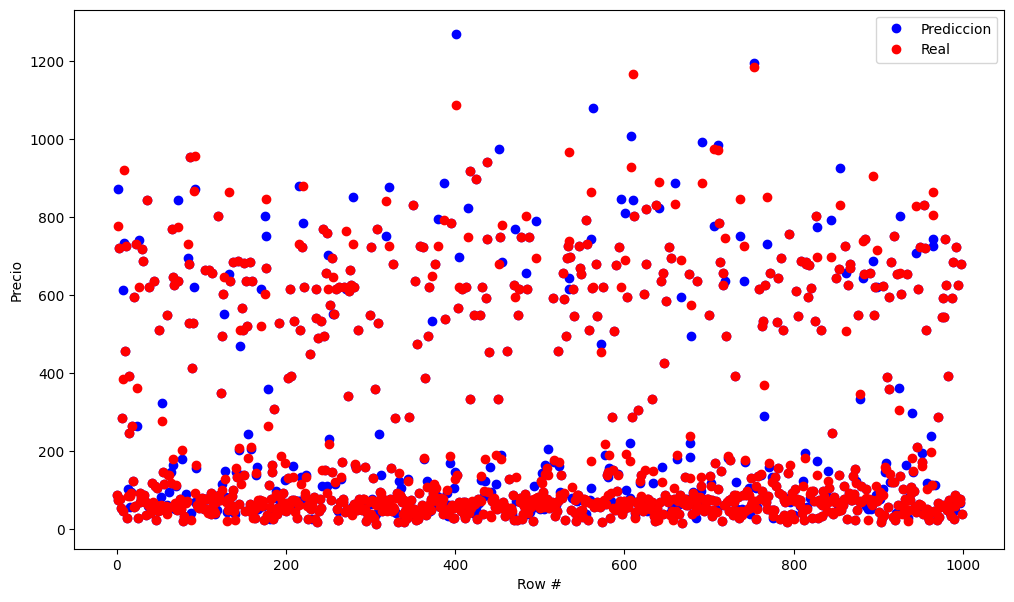

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(y_test_pred_tree2[:1000])),
         y_test_pred_tree2[:1000],
         'bo',
         label = 'Prediccion')

plt.plot(range(len(y_test[:1000])),
         y_test[:1000],
         'ro',
         label = 'Real')

plt.xlabel('Row #')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [ ]:
result1 = pd.DataFrame({'Precio_real':y_test,'Prediccion':y_test_pred_tree2})
result=flight_label.merge(result1, left_index=True,right_index=True)

In [ ]:
result.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class_flight,duration,days_left,price_usd,Precio_real,Prediccion
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,71,71,123.0
6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1,72,72,71.0
11,GO_FIRST,G8-338,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1,71,71,71.0
12,Indigo,6E-5001,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.17,1,71,71,71.0
16,Air_India,AI-887,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.08,1,71,71,71.0


Si lo evaluamos con respecto a la variable días restantes:

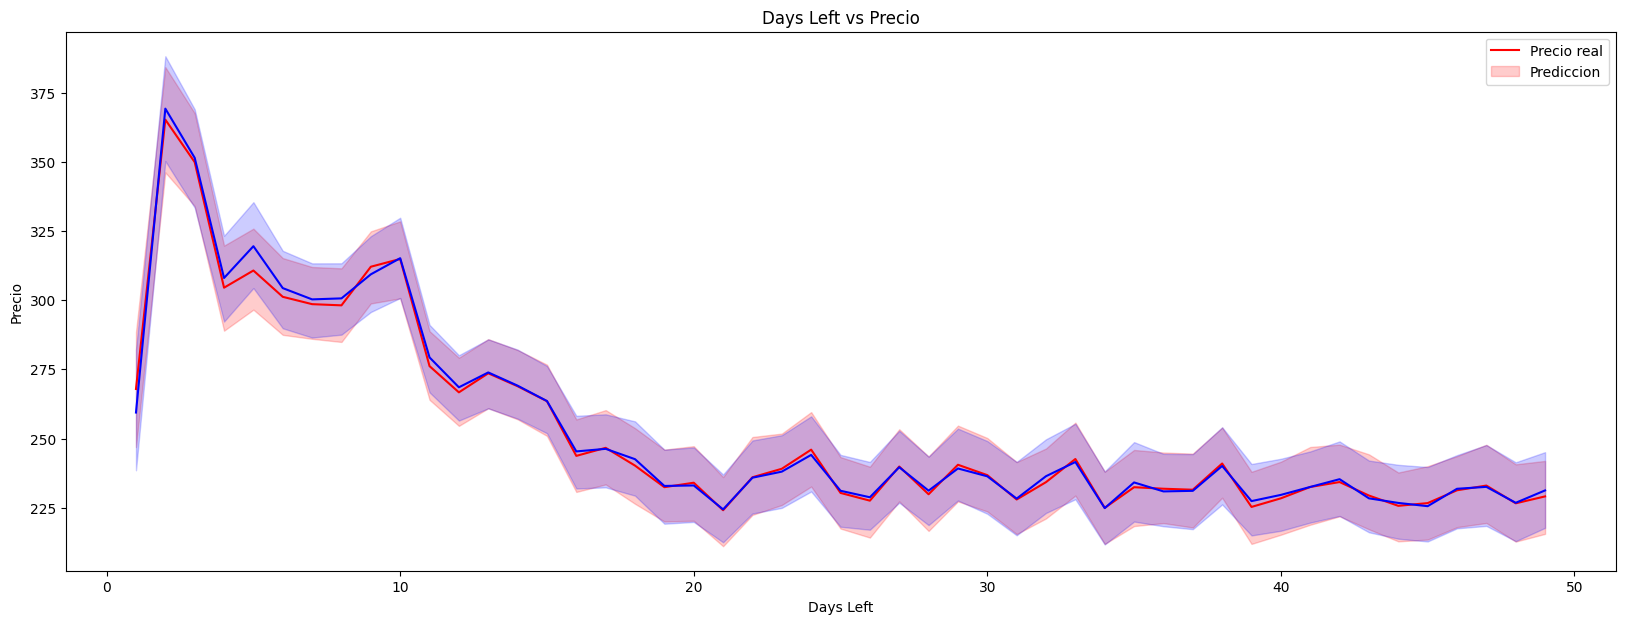

In [ ]:
plt.figure(figsize=(20,7))
sns.lineplot(data=result,x='days_left',y='Precio_real',color='red')
sns.lineplot(data=result,x='days_left',y='Prediccion',color='blue')
plt.title('Days Left vs Precio')
plt.legend(labels=['Precio real','Prediccion'])
plt.xlabel('Days Left')
plt.ylabel('Precio')
plt.show()

Veamos un ejemplo concreto. Queremos conocer el valor que predice el modelo para:

* Duration: 5
* Days left: 10
* Airline: Vistara
* Source city: Delhi
* Destination city: Mumbai
* Departure time: Afternoon
* Arrival time: Night
* Stops: Zero
* Class: Economy

In [ ]:
new_row = pd.DataFrame({
    'duration': 5, 'days_left': 10, 'airline_id': 3, 'source_city_id': 1, 'destination_city_id': 2, 'departure_time_id': 3, 'arrival_time_id': 5, 'stops_id': 0, 'class_id': 0
}, index=[99999999999])

In [ ]:
new_row

,duration,days_left,airline_id,source_city_id,destination_city_id,departure_time_id,arrival_time_id,stops_id,class_id
99999999999,5,10,3,1,2,3,5,0,0


In [ ]:
pred_new_row = tree_model2.predict(new_row)

In [ ]:
pred_new_row

array([126.])

El modelo predice un valor de 126 usd.

Al principio del proyecto se plantearon ciertas hipótesis:

**1- A mayor duración de vuelo, mayor precio**. VERDADERO (Sólo Economy)

Si consideramos la media del precio agrupando por duración del vuelo, para clase Economy se observa un aumento del precio a partir de las 25 hs. En el caso de Business, el precio va aumentando hasta las 10 hs, a partir del cual se mantiene estable.

**2- A mayor cantidad de días restantes para el vuelo, menor precio** VERDADERO

Si calculamos la media del precio agrupando por cantidad de días restantes al vuelo, para clase Economy se observa un precio mayor claramente definido en el rango de los últimos 15 días antes de partir. Mientras que para Business el rango es en los últimos 5 días.

**3- Aerolínea con precios de ticket más elevados es Vistara y el menor es AirAsia**. VERDADERO

Vistara y Air India presentan los mayores precios en Economy, mientras que AirAsia tiene los menores precios. En cuanto a clase Business, Vistara tiene mayores precios que Air India. Se presentan outliers.

**4- Las siguientes combinaciones son las más baratas**. FALSO

Combinación correcta:

[Ciudad origen] ---------> [Ciudad destino]

Hyderabad ---------> Delhi

Delhi ---------> Mumbai

Delhi ---------> Bangalore

Delhi ---------> Kolkata

Delhi ---------> Hyderabad

Hyderabad ---------> Chennai

**5- Los vuelos directos (cero escalas) presentan menor precio**. VERDADERO

Si diferenciamos por cantidad de escalas, se observan menores precios en vuelos directos, mientras que los vuelos de 1 escala presentan el precio máximo.

**6- Los vuelos que salen muy temprano (Early morning) son los más elegidos**. FALSO

El horario de salida más elegido por los usuarios varía con la ciudad de origen. Por ejemplo, en el caso de Bangalore es Evening, mientras que para Chennai es Morning. El único caso donde Early Morning es el horario más elegido es desde Mumbai.